In [1]:
import gensim
import json
import sys
from gensim.models import Word2Vec, Phrases, phrases, KeyedVectors

from sklearn.cluster import DBSCAN
from pyclustering.cluster.dbscan import dbscan
import numpy as np

import os
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA

## Read the sentences list

In [47]:
sentences = []
with open('../../Preprocess_venue/venues_unique.json', 'r') as f:
    sentences = json.loads(f.read())
print(len(sentences))

import itertools
sentences.sort()
list(sentences for sentences,_ in itertools.groupby(sentences))

3643


[['a-statistical', 'mechanics', 'applications'],
 ['abdominal', 'imaging'],
 ['abstraction', 'reformulation', 'approximation'],
 ['academic', 'librarianship'],
 ['academic', 'radiology'],
 ['academy'],
 ['academy', 'sciences'],
 ['academy', 'sciences-technical', 'sciences'],
 ['access'],
 ['access', 'control', 'models', 'technologies'],
 ['access', 'networks'],
 ['acimed'],
 ['acm'],
 ['acm', 'accessibility', 'computing'],
 ['acm', 'ada', 'letters'],
 ['acm', 'apl', 'quote', 'quad'],
 ['acm', 'applied', 'computing'],
 ['acm', 'applied', 'computing', 'review'],
 ['acm', 'architecture', 'news'],
 ['acm', 'communications', 'algebra'],
 ['acm', 'computers', 'physically', 'handicapped'],
 ['acm', 'computers', 'society'],
 ['acm', 'computing', 'cultural', 'heritage'],
 ['acm', 'computing', 'surveys'],
 ['acm', 'crossroads', 'student'],
 ['acm', 'documentation'],
 ['acm', 'emerging', 'technologies', 'computing', 'systems'],
 ['acm', 'experimental', 'algorithms'],
 ['acm', 'fortran', 'forum'],

In [48]:
len(sentences)

3643

## Load pretrained model

In [3]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)  

## Update Model

In [4]:
add_words = []
for sentence in sentences:
    word_vector = []
    
    for word in sentence:
        try:
            word_vector.append(model[word])
        except:
            add_words.append(word)

In [5]:
print(len(add_words))

606


In [6]:
# google_wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
min_count = 5
mmodel = Word2Vec(size=300, min_count=min_count, iter=10)
mmodel.build_vocab(add_words)
training_examples_count = mmodel.corpus_count

In [22]:
# below line will make it 1, so saving it before
mmodel.build_vocab([list(model.vocab.keys())], update=True)
mmodel.intersect_word2vec_format("./model/GoogleNews-vectors-negative300.bin",binary=True, lockf=1.0)
mmodel.train(add_words,total_examples=training_examples_count, epochs=mmodel.iter)

AttributeError: 'Word2Vec' object has no attribute 'vocab'

In [9]:
mmodel.save("./model/word2vec_model2")
model1 = Word2Vec.load("./model/word2vec_model2")
mmodel.wv.save("./model/word2vec_model_vectors2")

In [ ]:
google_wv = KeyedVectors.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)

In [44]:
model = Word2Vec(size=300, min_count=min_count, iter=10)
model = model.build_vocab(add_words)
training_examples_count = model.corpus_count
# below line will make it 1, so saving it before
model = model.build_vocab([list(google_wv.vocab.keys())], update=True)
model = model.intersect_word2vec_format("./model/GoogleNews-vectors-negative300.bin",binary=True, lockf=1.0)
model = model.train(add_words,total_examples=training_examples_count, epochs=model.iter)


model.save("./model/word2vec_model2")
#model1 = Word2Vec.load("word2vec_model")
model.wv.save("./model/word2vec_model_vectors2")

AttributeError: 'NoneType' object has no attribute 'corpus_count'

In [36]:
model_2 = gensim.models.word2vec.Word2Vec(add_words, min_count=1)
google_wv.reset_from(model_2)
#google_wv.similarity('third','sentence')

AttributeError: 'Word2VecKeyedVectors' object has no attribute 'reset_from'

In [39]:
model_2['sentence']

c:\users\cristina\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'sentence' not in vocabulary"

In [33]:
X = []
model1 = Word2Vec.load("./model/word2vec_model2")
wrong_words = 0
total_words = 0
len_lower = 0

for sentence in sentences:
    word_vector = []
    
    for word in sentence:
        total_words += 1
        try:
            word_vector.append(model1[word])
        except:
            wrong_words += 1
    leng = len(word_vector)
    
    avg_vect = np.zeros(100)    
    if (leng > 0):
        for elem in word_vector:
            for i in range(0,100):
                avg_vect[i] += elem[i]
        
        if (leng != 1):
            for i in range(0,100):
                avg_vect[i] /= leng 
        
        X.append(avg_vect)    

c:\users\cristina\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [34]:
print(len(X))
print(wrong_words)
print(len_lower)

0
10689
0


In [10]:
X = np.array(X)
np.save('X1.npy', X) 
print(len(X))

3576


In [2]:
X = np.load('X1.npy')
print(len(X))

3576


## Apply DBScan

In [11]:
eps = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,
      2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,
      3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,
      4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,
      5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,
      6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,
      7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,
      8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,
      9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,
      10.0,10.1,10.2,10.3,10.4,10.5,10.6,10.7,10.8,10.9]
i = 0
while i < 100:
    min_s = 1
    while min_s < 10:
        clustering = DBSCAN(eps=eps[i], min_samples=min_s).fit(X)
        l = []
        cl = clustering.labels_
        min_ones = 0
        for element in cl:
            if element == -1:
                min_ones = min_ones + 1
            else:
                if element not in l:
                    l.append(element)
        print('eps=' + str(eps[i]) + ' min_s=' + str(min_s) + ' nr_clusters=' + str(len(l)) + ' nr_-1=' + str(min_ones))
        min_s = min_s + 1
    i = i + 1

eps=1.0 min_s=1 nr_clusters=182 nr_-1=0
eps=1.0 min_s=2 nr_clusters=10 nr_-1=172
eps=1.0 min_s=3 nr_clusters=2 nr_-1=188
eps=1.0 min_s=4 nr_clusters=1 nr_-1=204
eps=1.0 min_s=5 nr_clusters=1 nr_-1=205
eps=1.0 min_s=6 nr_clusters=1 nr_-1=209
eps=1.0 min_s=7 nr_clusters=1 nr_-1=221
eps=1.0 min_s=8 nr_clusters=1 nr_-1=226
eps=1.0 min_s=9 nr_clusters=1 nr_-1=230
eps=1.1 min_s=1 nr_clusters=74 nr_-1=0
eps=1.1 min_s=2 nr_clusters=5 nr_-1=69
eps=1.1 min_s=3 nr_clusters=1 nr_-1=77
eps=1.1 min_s=4 nr_clusters=1 nr_-1=79
eps=1.1 min_s=5 nr_clusters=1 nr_-1=82
eps=1.1 min_s=6 nr_clusters=1 nr_-1=83
eps=1.1 min_s=7 nr_clusters=1 nr_-1=85
eps=1.1 min_s=8 nr_clusters=1 nr_-1=85
eps=1.1 min_s=9 nr_clusters=1 nr_-1=91
eps=1.2 min_s=1 nr_clusters=33 nr_-1=0
eps=1.2 min_s=2 nr_clusters=2 nr_-1=31
eps=1.2 min_s=3 nr_clusters=1 nr_-1=33
eps=1.2 min_s=4 nr_clusters=1 nr_-1=33
eps=1.2 min_s=5 nr_clusters=1 nr_-1=34
eps=1.2 min_s=6 nr_clusters=1 nr_-1=36
eps=1.2 min_s=7 nr_clusters=1 nr_-1=36
eps=1.2 min_s=8

KeyboardInterrupt: 

## Test DBScan

In [23]:
clustering = DBSCAN(eps=1.2, min_samples=1).fit(X)
cl = clustering.labels_

# Gaseste numarul de clustere
clust = []
noise = 0

for elem in cl: 
    if elem == -1:
        noise += 1
    else:
        if elem not in clust:
            clust.append(elem)

clustere = np.zeros(len(clust), dtype=np.int64)     
for elem in cl:
    if not ( elem == -1):
        clustere[elem] += 1 
        
print(clustere)

[3007    1    1    1    1    1    1    1    1    2    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1]


## Apply DBScan 2

In [18]:
sample = X

eps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,
      1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,
      2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,
      3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,
      4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,
      5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,
      6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,
      7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,
      8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,
      9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,
      10.0,10.1,10.2,10.3,10.4,10.5,10.6,10.7,10.8,10.9]
i = 0
while i < 100:
    min_s = 1
    while min_s < 10:

        dbscan_instance = dbscan(sample, eps[i], min_s)
        dbscan_instance.process()
        clusters = dbscan_instance.get_clusters()
        noise = dbscan_instance.get_noise()
        print(str(eps[i]) + ' ' + str(min_s) + ' clusters=' + str(len(clusters)) + ' noise=' + str(len(noise)))
        min_s += 1
    
    i += 1


0.1 1 clusters=52 noise=2929
0.1 2 clusters=7 noise=3019
0.1 3 clusters=0 noise=3040
0.1 4 clusters=0 noise=3040
0.1 5 clusters=0 noise=3040
0.1 6 clusters=0 noise=3040
0.1 7 clusters=0 noise=3040
0.1 8 clusters=0 noise=3040
0.1 9 clusters=0 noise=3040
0.2 1 clusters=52 noise=2929
0.2 2 clusters=7 noise=3019
0.2 3 clusters=0 noise=3040
0.2 4 clusters=0 noise=3040
0.2 5 clusters=0 noise=3040
0.2 6 clusters=0 noise=3040
0.2 7 clusters=0 noise=3040
0.2 8 clusters=0 noise=3040
0.2 9 clusters=0 noise=3040
0.3 1 clusters=57 noise=2918
0.3 2 clusters=8 noise=3016
0.3 3 clusters=0 noise=3040
0.3 4 clusters=0 noise=3040
0.3 5 clusters=0 noise=3040
0.3 6 clusters=0 noise=3040
0.3 7 clusters=0 noise=3040
0.3 8 clusters=0 noise=3040
0.3 9 clusters=0 noise=3040
0.4 1 clusters=105 noise=2790
0.4 2 clusters=19 noise=2962
0.4 3 clusters=8 noise=2999
0.4 4 clusters=1 noise=3030
0.4 5 clusters=1 noise=3031
0.4 6 clusters=1 noise=3032
0.4 7 clusters=1 noise=3032
0.4 8 clusters=0 noise=3040
0.4 9 clusters

KeyboardInterrupt: 

## Test DBScan 2

In [19]:
dbscan_instance = dbscan(sample, 0.9, 1)
dbscan_instance.process()
clusters = dbscan_instance.get_clusters()
noise = dbscan_instance.get_noise()

clust = np.zeros(len(clusters))
index = 0
for elem in clusters:
    print(index, len(elem))
    index += 1

0 2595
1 2
2 2
3 5
4 2
5 2
6 2
7 2
8 2
9 2
10 3
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2


## Apply Hierarchical Clustering

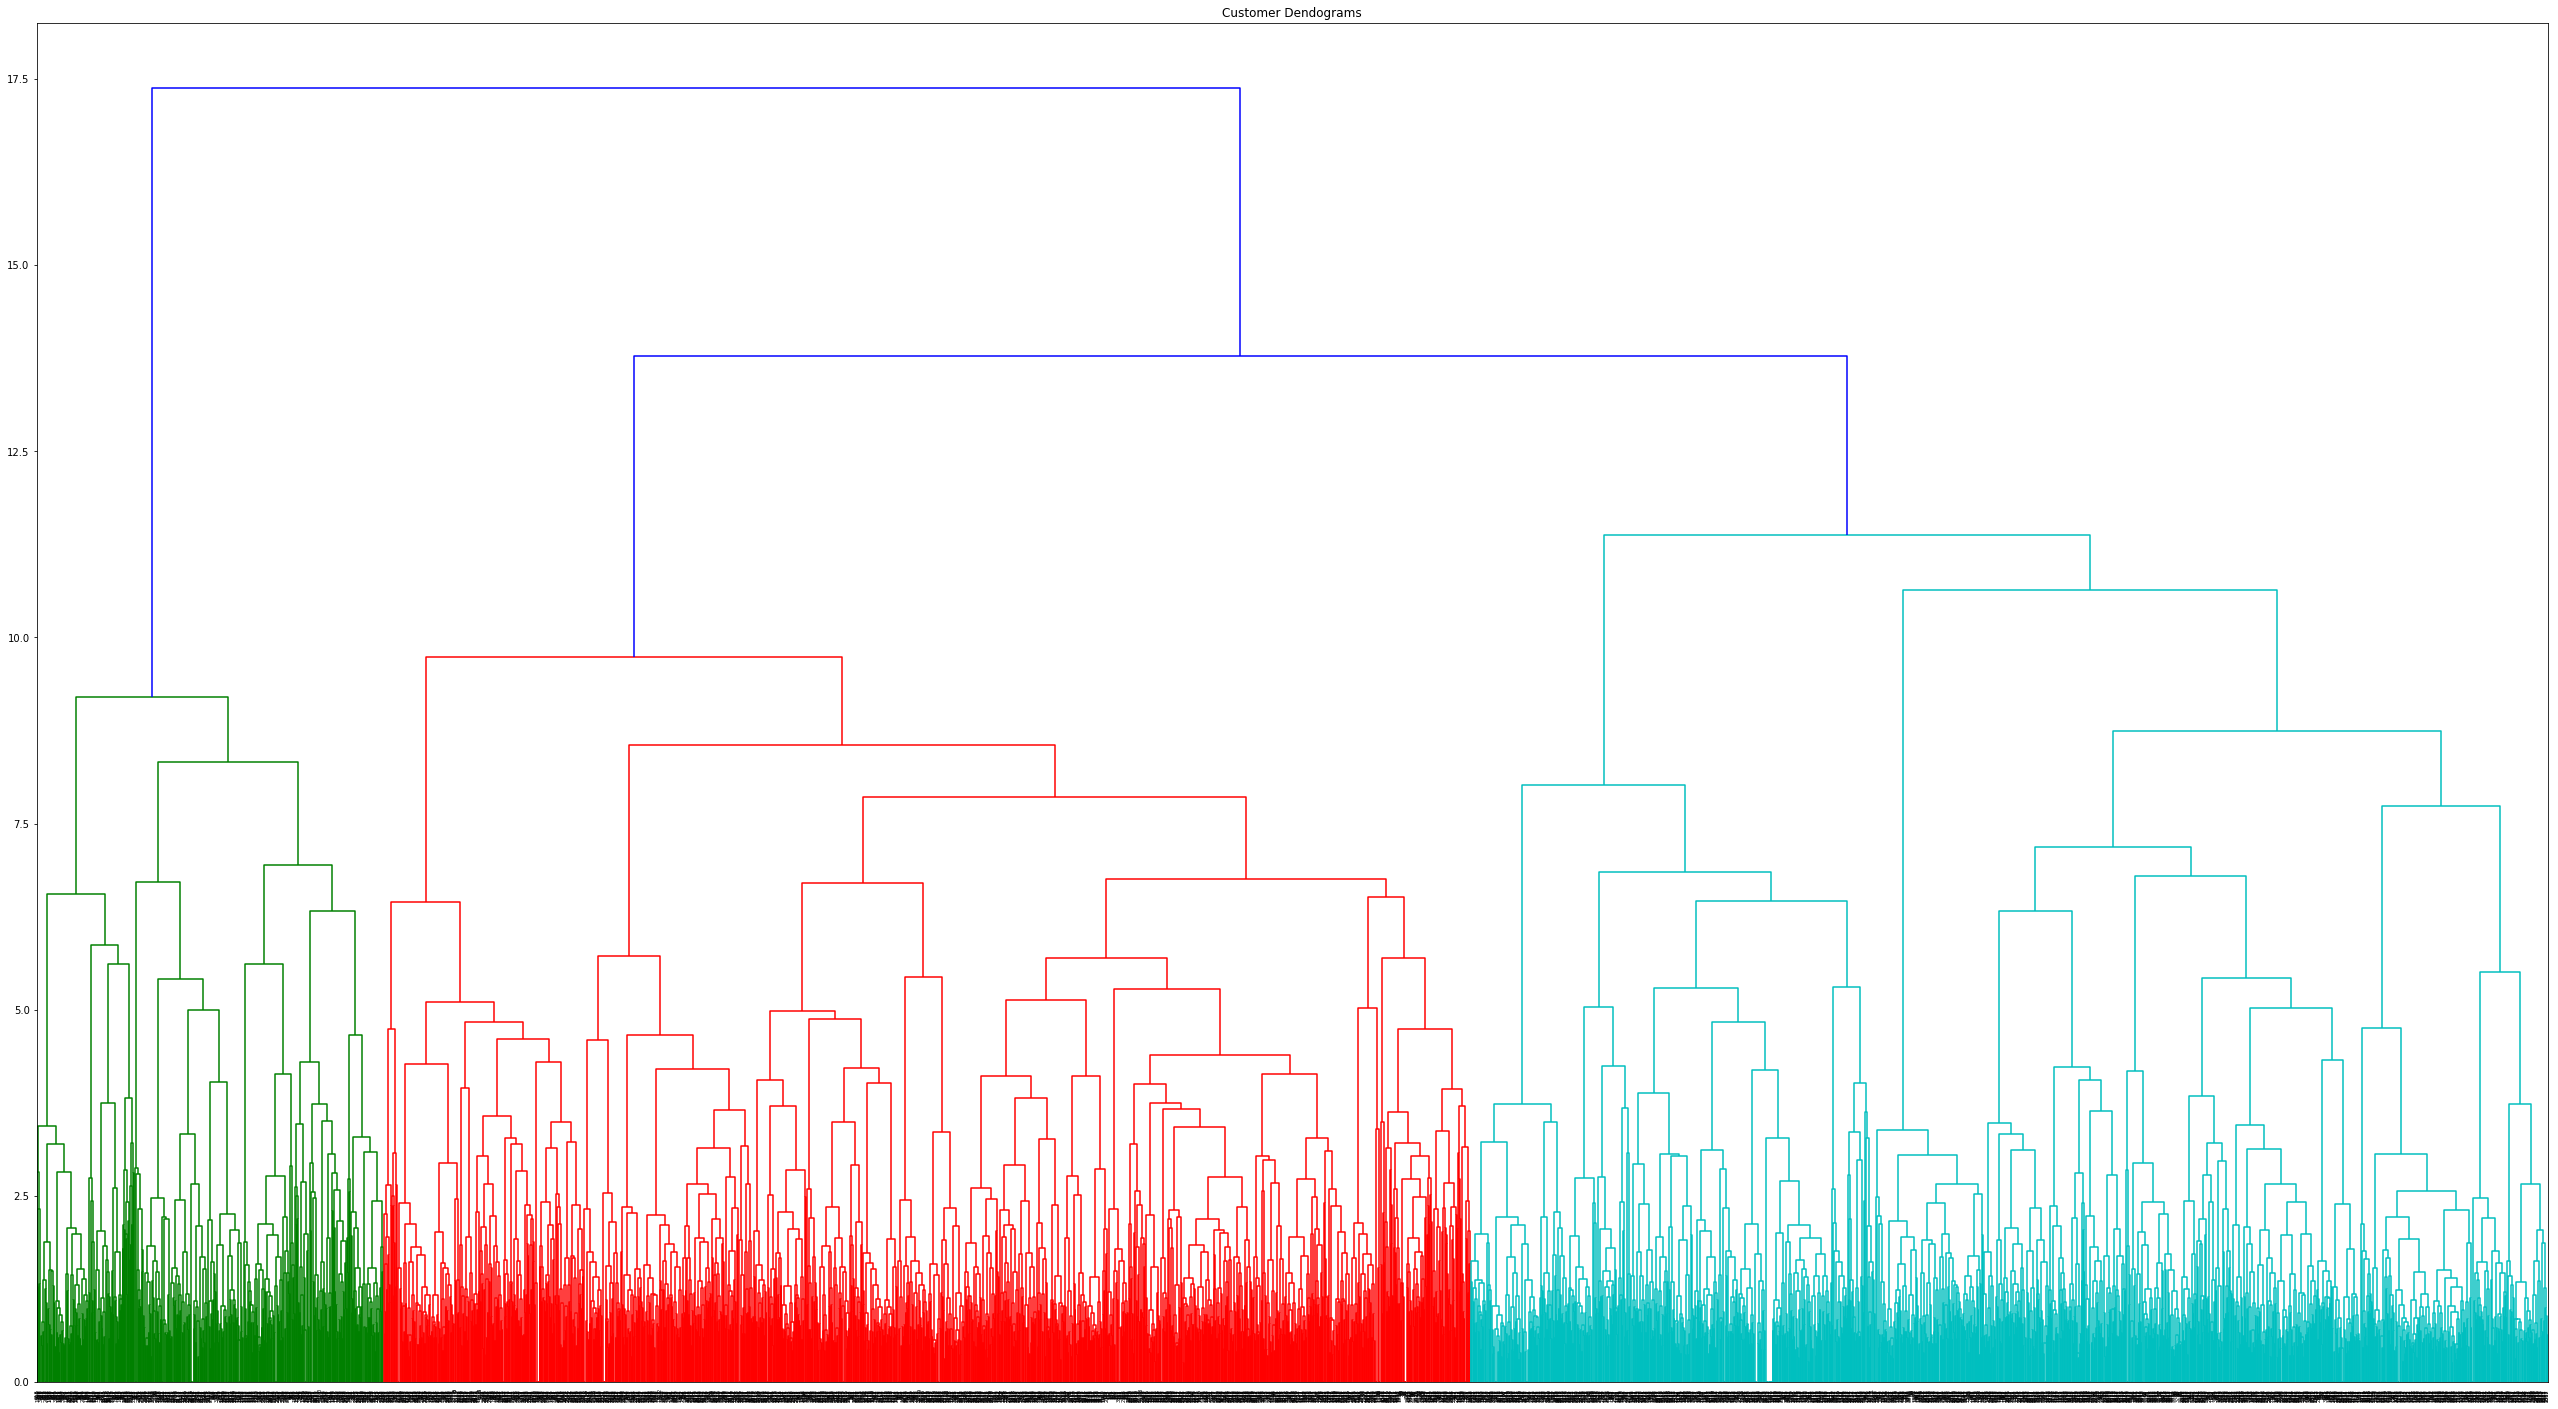

In [11]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt 
data = X
max_d = 50

plt.figure(figsize=(45, 25))  
plt.title("Customer Dendograms")  
plt.axhline(y=max_d, c='k')
Z = shc.linkage(data, method='ward')
dend = shc.dendrogram(Z)  

## Elbow Method

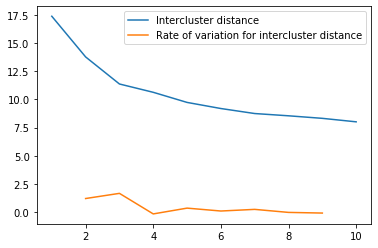

clusters: 3


In [4]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev, label="Intercluster distance")

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev, label= "Rate of variation for intercluster distance")
plt.legend(loc='upper right')
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

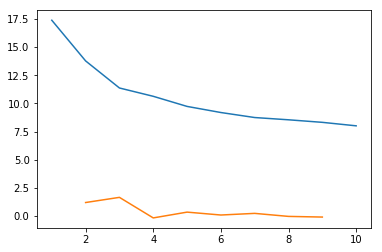

clusters: 3


In [13]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

## Pentru Tensorboard

In [13]:
pca = sklearnPCA(n_components=50) #2-dimensional PCA
pca_df = pd.DataFrame(pca.fit_transform(X))
df_pca = pca_df.values

tf_data = tf.Variable(df_pca)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
PATH = os.getcwd()

LOG_DIR = PATH + './log-1'

#metadata = os.path.join(LOG_DIR, 'cl.tsv')

tf_data = tf.Variable(df_pca)

with tf.Session() as sess:
    saver = tf.train.Saver([tf_data])
    sess.run(tf.global_variables_initializer())
    saver.save(sess, os.path.join(LOG_DIR, 'tf_data.ckpt'))
    config = projector.ProjectorConfig()
    
    embedding = config.embeddings.add()
    embedding.tensor_name = tf_data.name
    
    #embedding.metadata_path = metadata
    
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)